In [81]:
import os
from sklearn.linear_model import PoissonRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error 
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import poisson
from scipy.stats import nbinom
from patsy import dmatrices
os.chdir(os.path.expanduser("~/Desktop/Classes/Research/deep_uncertainty/deep_uncertainty"))
from deep_uncertainty.evaluation.calibration import compute_mean_calibration, plot_regression_calibration_curve, display_bayes_credible_interval

# Bikes Data

Poisson

In [243]:
bikes = pd.read_csv('deep_uncertainty/data/bikes/hour.csv')
bikes = bikes[:1000]

In [244]:
bikes = bikes.drop(['dteday', 'instant', 'registered'], axis=1)
X = bikes.iloc[:,:-1]
mask = np.random.rand(len(bikes)) < 0.8
df_train = bikes[mask]
df_test = bikes[~mask]

expr = "cnt ~ " + " + ".join(bikes.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()
# print(poisson_training_results.summary())

In [245]:
y_preds = poisson_testing_results.mu
posterior_predictive = poisson(mu=y_preds)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[  6.,  31.],
       [ 20.,  57.],
       [ 19.,  56.],
       [ 68., 128.],
       [110., 185.],
       [ 32.,  77.],
       [  4.,  26.],
       [  6.,  31.],
       [  6.,  31.],
       [  5.,  29.]])

In [246]:
y_test[:10].values

array([[ 16.],
       [ 14.],
       [ 36.],
       [ 56.],
       [110.],
       [ 67.],
       [ 17.],
       [  3.],
       [  1.],
       [  8.]])

In [247]:
mse = mean_squared_error(y_preds, y_test)
mse

1208.3329341081173

In [248]:
bikes['cnt'].mean()

58.304

In [249]:
bikes['cnt'].std()

50.985557867999404

In [250]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.4539577117851743

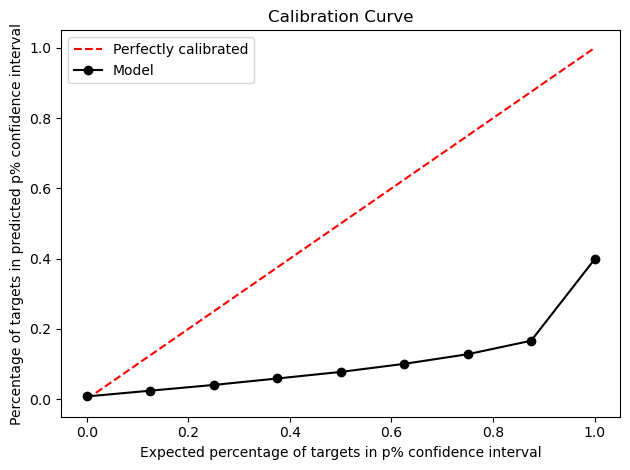

In [251]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

Negative Binomial

In [252]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_45676/4066697801.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_45676/4066697801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['cnt'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_45676/4066697801.p

In [254]:
y_preds = predicted_counts
y_test = y_test['cnt']
# n is # of successes
n = successes
# p is the probability of success
p = successes / len(y_test)
posterior_predictive = nbinom(p=p, n=n)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[  8., 809.],
       [ 14., 700.],
       [ 17., 670.],
       [ 25., 600.],
       [ 32., 550.],
       [ 21., 630.],
       [  6., 851.],
       [  7., 832.],
       [  7., 814.],
       [  7., 818.]])

In [255]:
mse = mean_squared_error(y_preds, y_test)
mse

2140.8836638321295

In [256]:
y_test[:10].values

array([ 16.,  14.,  36.,  56., 110.,  67.,  17.,   3.,   1.,   8.])

In [257]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.5217702149642973

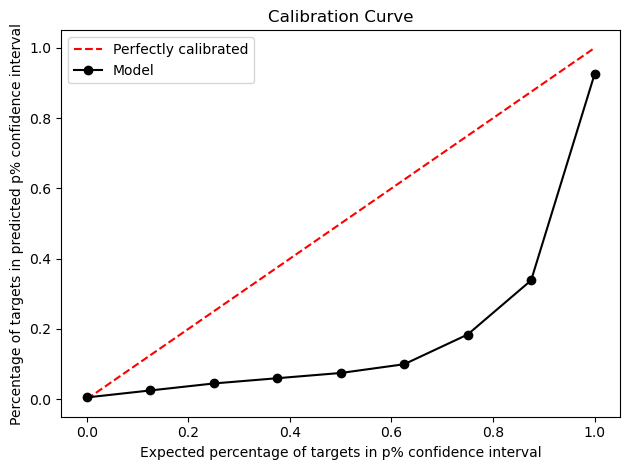

In [258]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

# Sales Data

Poisson

In [18]:
sales = pd.read_csv('deep_uncertainty/data/dominicks/cleaned_bath_counts.csv', low_memory=False)

In [19]:
sales = sales.drop(columns=['SALE', 'PRICE_HEX', 'PROFIT_HEX'], axis=1)
big_sales = sales.copy()
big_sales

,UPC,STORE,WEEK,QTY,PRICE,PROFIT,OK,NAME,CITY,ZIP,...,GROUP4,GROUP5,GROUP6,GROUP7,GROUP8,GROUP9,GROUP10,GROUP11,GROUP12,MOVE
0,5690310,70,348,1,0.0,0.00,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,0
1,5690310,70,349,1,0.0,0.00,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,0
2,5690310,70,350,1,0.0,0.00,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,0
3,5690310,70,351,1,2.5,14.48,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,1
4,5690310,70,352,1,0.0,0.00,1,b'DOMINICKS 70',b'JOLIET',60435.0,...,0.108954,0.170252,0.220969,0.048531,0.052903,0.134225,0.165530,0.027807,0.022211,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14993364,78936105002,134,395,1,0.0,0.00,1,b'DOMINICKS 134',b'WEST CHICAGO',60185.0,...,0.068119,0.155437,0.397083,0.027137,0.038213,0.181097,0.051874,0.013845,0.020491,0
14993365,78936105002,134,396,1,0.0,0.00,1,b'DOMINICKS 134',b'WEST CHICAGO',60185.0,...,0.068119,0.155437,0.397083,0.027137,0.038213,0.181097,0.051874,0.013845,0.020491,0
14993366,78936105002,134,397,1,0.0,0.00,1,b'DOMINICKS 134',b'WEST CHICAGO',60185.0,...,0.068119,0.155437,0.397083,0.027137,0.038213,0.181097,0.051874,0.013845,0.020491,0
14993367,78936105002,134,398,1,0.0,0.00,1,b'DOMINICKS 134',b'WEST CHICAGO',60185.0,...,0.068119,0.155437,0.397083,0.027137,0.038213,0.181097,0.051874,0.013845,0.020491,0


In [20]:
med_sales = big_sales[:5000000]

In [109]:
sales = sales[:10000]

In [110]:
from sklearn.preprocessing import LabelEncoder

big_sales = big_sales.apply(LabelEncoder().fit_transform)
med_sales = med_sales.apply(LabelEncoder().fit_transform)

sales = sales.apply(LabelEncoder().fit_transform)
sales

,UPC,STORE,WEEK,QTY,PRICE,PROFIT,OK,NAME,CITY,ZIP,...,GROUP4,GROUP5,GROUP6,GROUP7,GROUP8,GROUP9,GROUP10,GROUP11,GROUP12,MOVE
0,0,0,164,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,165,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,166,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,167,0,34,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,168,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,107,0,119,0,18,602,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9996,107,0,120,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,107,0,121,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,107,0,122,0,0,5,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [292]:
X = sales.iloc[:,:-1]
mask = np.random.rand(len(sales)) < 0.8
df_train = sales[mask]
df_test = sales[~mask]

expr = "MOVE ~ " + " + ".join(sales.columns[:-1])
expr

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
poisson_testing_results = sm.GLM(y_test, X_test, family=sm.families.Poisson()).fit()

In [293]:
y_preds = poisson_testing_results.mu
posterior_predictive = poisson(mu=y_preds)
posterior_predictive
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.],
       [0., 2.]])

In [294]:
y_test[:10].values

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [295]:
print(y_preds)
len(y_preds)

[0.06460181 0.06346074 0.06308488 ... 0.27329074 0.30692767 0.30510983]


2046

In [296]:
mse = mean_squared_error(y_preds, y_test)
mse

1.0120171797864215

In [297]:
np.sqrt(mse)

1.00599064597362

In [298]:
sales['MOVE'].mean()

0.4286

In [299]:
sales['MOVE'].std()

1.0372124280792185

In [300]:
# Poisson calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.64101383424947

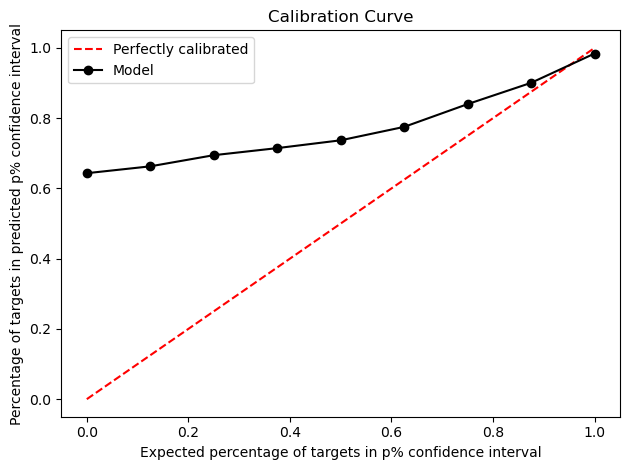

In [301]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

Negative Binomial

In [302]:
df_train["BB_LAMBDA"] = poisson_training_results.mu
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['MOVE'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()
nb2_predictions = nb2_training_results.get_prediction(X_test)
successes = nb2_training_results.predict(X_test, linear=True)
predictions_summary_frame = nb2_predictions.summary_frame()
predicted_counts=predictions_summary_frame['mean']


# Count number of successful predictions
# success_threshold = 1
# test_predictions = np.array(successes)
# y_test_values = y_test.values.flatten()
# absolute_differences = np.abs(test_predictions - y_test_values)
# successful_predictions_count = np.sum(absolute_differences <= success_threshold)
# print("Number of successful predictions:", successful_predictions_count)

/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_45676/3350743688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["BB_LAMBDA"] = poisson_training_results.mu
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_45676/3350743688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['MOVE'] - x['BB_LAMBDA'])**2 - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
/var/folders/xg/5n69np453nn3pzzpyw20jrp40000gn/T/ipykernel_45676/3350743688.

In [303]:
y_preds = predicted_counts
y_test = y_test['MOVE']
# n is # of successes
n = successes
# p is the probability of success
p = n / len(y_test)
posterior_predictive = nbinom(p=p, n=n)
np.column_stack([posterior_predictive.ppf(0.001), posterior_predictive.ppf(0.999)])[:10]

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]])

In [304]:
y_test[:10].values

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [305]:
mse = mean_squared_error(y_preds, y_test)
mse

1.2286026043686047

In [306]:
np.sqrt(mse)

1.10842347700173

In [307]:
# Negative Binomial calibration
compute_mean_calibration(np.array(y_test), posterior_predictive)

0.36056974798564867

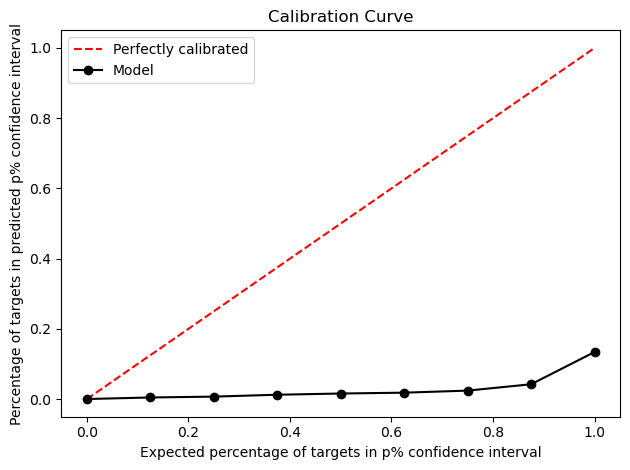

In [308]:
plot_regression_calibration_curve(np.array(y_test), posterior_predictive, num_bins=9)

In [309]:
n

10      -3.058432
13      -3.072274
14      -3.076888
18      -3.095344
22      -3.113801
          ...    
9966     0.107581
9967   -22.953533
9984    -1.504374
9988    -1.338431
9989    -1.343045
Length: 2046, dtype: float64

In [310]:
p

10     -0.001495
13     -0.001502
14     -0.001504
18     -0.001513
22     -0.001522
          ...   
9966    0.000053
9967   -0.011219
9984   -0.000735
9988   -0.000654
9989   -0.000656
Length: 2046, dtype: float64